# Homework 3 - Interactive Viz

In [1]:
import folium
import requests as rq
from bs4 import BeautifulSoup as bfs
import numpy as np
import pandas as pd
import collections
import os
%matplotlib inline
import matplotlib.pyplot as plt
from dateutil import relativedelta
import scipy.stats as stats
import math
import json
from pprint import pprint
from ipywidgets import FloatProgress
from IPython.display import display
from geopy.geocoders import GeoNames, Nominatim, GoogleV3
import locale
import seaborn as sns

topojson_cantons = r'ch-cantons.topojson.json'

*Note for the reader: All cells of the Notebook have been executed. However, the entire Notebook can be executed again. In order to do so, please make sure that you have all the libraries installed. If it is not the case, you have to install them manually.*

## Context

Swiss National Science Foundation is a private and independent organisation in charge of repartition of funds toward the different universities, research centers, laboraties, and so on.

In compliance with regulations and for the purpose of transparency, SNSF published online all data regarding the projects it has supported. These data, which are keeped up to date, can be found online, on <a href="http://p3.snf.ch/Pages/DataAndDocumentation.aspx">SNSF's official website</a>.

In the present Notebook, we are going to manipulate these data and more specifically data regarding Swiss institutions (public as private) to retrieve some interesting facts as allocated amount to the different cantons of the Swiss Confederation.

With this aim in mind, we'll firstly gather all data. Then, we will compute the amount of money allowed to different universities. Finally, we'll display results on an interactive map using different libraries.

## Preliminary analysis and familiarisation with libraries (test map)

Before manipulating data, and as proposed in instructions, we propose to familiarise with tools we will use in the present Notebook. In particular, we propose to use provided <a href="https://github.com/mbostock/topojson">TopoJSON</a> (map of Switzerland divided by cantons) to display it with <a href="https://github.com/python-visualization/folium">Folium</a>.

The intermediate visualisation consists of displaying Swiss cantons according to amount of money (let's say in million) they received during the past years.

Note: Of course, here we use randomly-generated approved amount.

In [2]:
# We first retrieve all information of TopoJSON
with open(topojson_cantons) as data_file:    
    ch_cantons_json = json.load(data_file)

# We loop on the JSON file in order to get the initials of each canton.
# Moreover, we associate a random number to each canton.
cantons_id = [canton['id'] for canton in ch_cantons_json['objects']['cantons']['geometries']]
data_test = pd.DataFrame({
        'canton': cantons_id,
        'value': np.random.randint(0, 100, len(cantons_id))
    })
data_test.head()

,canton,value
0,ZH,32
1,BE,41
2,LU,2
3,UR,53
4,SZ,57


Now we generated false data, we create the Folium map using provided TopoJSON and the aforesaid data.

In [3]:
# topojson: Reference to all Swiss cantons
# data: Data associated to cantons and used to color the map
# threshold_scale: Scale used for data (here, we set a linear scale)
map_test = folium.Map(location=[46.8, 8.1], zoom_start=8)
map_test.choropleth(
    geo_path=topojson_cantons,
    topojson='objects.cantons',
    data=data_test,
    columns=['canton', 'value'],
    key_on='feature.id',
    fill_color='PuBuGn',
    fill_opacity=0.5,
    line_opacity=0.7,
    threshold_scale=list(np.linspace(data_test['value'].min(), data_test['value'].max(), 6)),
    reset=True
)
map_test

## SNSF data

### Grant CSV file

Even if SNSF provides a consequent set of information about data, in our case, we only use information gathered in *P3_GrantExport.csv* file.

Having downloaded the file, we open it with a data parser in order to manipulate date more easily.

*Note: The following cell can take some time to run, because of volume of data.*

In [4]:
snsf_data = pd.read_csv('Data/P3_GrantExport.csv', sep=';', parse_dates=['Start Date', 'End Date'])
snsf_data.head()

,"﻿""Project Number""",Project Title,Project Title English,Responsible Applicant,Funding Instrument,Funding Instrument Hierarchy,Institution,University,Discipline Number,Discipline Name,Discipline Name Hierarchy,Start Date,End Date,Approved Amount,Keywords
0,1,Schlussband (Bd. VI) der Jacob Burckhardt-Biog...,NaN,Kaegi Werner,Project funding (Div. I-III),Project funding,NaN,Nicht zuteilbar - NA,10302,Swiss history,Human and Social Sciences;Theology & religious...,1975-01-10,1976-09-30,11619.00,NaN
1,4,Batterie de tests à l'usage des enseignants po...,NaN,Massarenti Léonard,Project funding (Div. I-III),Project funding,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,10104,Educational science and Pedagogy,"Human and Social Sciences;Psychology, educatio...",1975-01-10,1976-09-30,41022.00,NaN
2,5,"Kritische Erstausgabe der ""Evidentiae contra D...",NaN,Kommission für das Corpus philosophorum medii ...,Project funding (Div. I-III),Project funding,Kommission für das Corpus philosophorum medii ...,"NPO (Biblioth., Museen, Verwalt.) - NPO",10101,Philosophy,Human and Social Sciences;Linguistics and lite...,1976-01-03,1985-02-28,79732.00,NaN
3,6,Katalog der datierten Handschriften in der Sch...,NaN,Burckhardt Max,Project funding (Div. I-III),Project funding,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,10302,Swiss history,Human and Social Sciences;Theology & religious...,1975-01-10,1976-09-30,52627.00,NaN
4,7,Wissenschaftliche Mitarbeit am Thesaurus Lingu...,NaN,Schweiz. Thesauruskommission,Project funding (Div. I-III),Project funding,Schweiz. Thesauruskommission,"NPO (Biblioth., Museen, Verwalt.) - NPO",10303,Ancient history and Classical studies,Human and Social Sciences;Theology & religious...,1976-01-01,1978-04-30,120042.00,NaN


### Description of fields and data processing

Before manipulating data, it is important to describe them in order to understand and anticipate possible issues we may encounter.

In our case, data are provided by SNSF. As the organisation provides a full description of all fields and in order to avoid overloading Notebook, we redirect the reader to the <a href="http://p3.snf.ch/Pages/DataAndDocumentation.aspx">SNSF's official website</a>.

First, let's display the type of each column to get some intuition about format of data.

In [5]:
snsf_data.dtypes

﻿"Project Number"                        int64
Project Title                           object
Project Title English                   object
Responsible Applicant                   object
Funding Instrument                      object
Funding Instrument Hierarchy            object
Institution                             object
University                              object
Discipline Number                        int64
Discipline Name                         object
Discipline Name Hierarchy               object
Start Date                      datetime64[ns]
End Date                        datetime64[ns]
Approved Amount                         object
Keywords                                object
dtype: object

As expected, we have the Project number and the Discipline Number set as integers while Start Date and End Date are designated as dates, thanks to applied parser.

However, some columns draw our attention to some concerns. For example, first column includes quotation marks, which can be problematic during manipulation. Also, some fields have a different type from which expected, like Approved Amount, which is here described as an object instead of an integer. We thus suppose that some data are missing. We'll thus do some further checks about this kind of issues during data handling.

Now, the first thing we want to do is to set the project number as the index of our dataset. Intuitively, data of this column are unique. And probably, there is no empty values. Let's confirm these facts.

*Note: Here, we take advantage of the opportunity to rename the column to get rid of these quotation marks, as they are not useful at all here (quite the reverse).*

In [6]:
snsf_data.columns = snsf_data.columns.str.replace(snsf_data.columns[0], 'Project Number')
print('Values are unique: %r' % snsf_data['Project Number'].is_unique)
print('Number of null values: %d' % sum(pd.isnull(x) for x in snsf_data['Project Number']))

Values are unique: True
Number of null values: 0


Fortunately, there is no duplicates or null values for this field so we set column as index.

In [7]:
snsf_data.set_index('Project Number', inplace=True)
snsf_data.head()

,Project Title,Project Title English,Responsible Applicant,Funding Instrument,Funding Instrument Hierarchy,Institution,University,Discipline Number,Discipline Name,Discipline Name Hierarchy,Start Date,End Date,Approved Amount,Keywords
Project Number,,,,,,,,,,,,,,
1,Schlussband (Bd. VI) der Jacob Burckhardt-Biog...,NaN,Kaegi Werner,Project funding (Div. I-III),Project funding,NaN,Nicht zuteilbar - NA,10302,Swiss history,Human and Social Sciences;Theology & religious...,1975-01-10,1976-09-30,11619.00,NaN
4,Batterie de tests à l'usage des enseignants po...,NaN,Massarenti Léonard,Project funding (Div. I-III),Project funding,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,10104,Educational science and Pedagogy,"Human and Social Sciences;Psychology, educatio...",1975-01-10,1976-09-30,41022.00,NaN
5,"Kritische Erstausgabe der ""Evidentiae contra D...",NaN,Kommission für das Corpus philosophorum medii ...,Project funding (Div. I-III),Project funding,Kommission für das Corpus philosophorum medii ...,"NPO (Biblioth., Museen, Verwalt.) - NPO",10101,Philosophy,Human and Social Sciences;Linguistics and lite...,1976-01-03,1985-02-28,79732.00,NaN
6,Katalog der datierten Handschriften in der Sch...,NaN,Burckhardt Max,Project funding (Div. I-III),Project funding,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,10302,Swiss history,Human and Social Sciences;Theology & religious...,1975-01-10,1976-09-30,52627.00,NaN
7,Wissenschaftliche Mitarbeit am Thesaurus Lingu...,NaN,Schweiz. Thesauruskommission,Project funding (Div. I-III),Project funding,Schweiz. Thesauruskommission,"NPO (Biblioth., Museen, Verwalt.) - NPO",10303,Ancient history and Classical studies,Human and Social Sciences;Theology & religious...,1976-01-01,1978-04-30,120042.00,NaN


As we said previously, values of 'Approved Amount' column are objects. Thus, we need to cast them to numeric in order to be able to compute the sum easily.<br/>


In our case, it is important to notice that 10910 values cannot be casted to numeric (see below) for two reasons, which are described in official documentation :

    - "This amount is not indicated in the case of mobility fellowships since it depends on administrative factors,
    typically the destination, cost of living, family allowances (if applicable) and exchange rate differences."
    
    - "Also in the case of NCCRs this amount is not available in P3"
     
 
*Note: Regarding the second reason, we made some brief investigation and, <a href="http://www.snf.ch/SiteCollectionDocuments/nfs/nccr_guide_2016.pdf">according to SNSF</a>, NCCR financial helps are attributed to the cantons which receive the most the funds of the organisation. Thus, we can safely conclude that not having these data won't greatly impact our study. Of course, in such situation, it would be preferable to handle data on their globality.*

In [8]:
snsf_data['Approved Amount'] = pd.to_numeric(snsf_data['Approved Amount'], errors='coerce')
snsf_data['Approved Amount'].value_counts(dropna=False).head()

NaN         10910
 10000.0      611
 5000.0       348
 8000.0       320
 15000.0      273
Name: Approved Amount, dtype: int64

In our study, we are interested on manipulating data relative to Swiss public (respectively private) organisations. However, from the documentation, we learn the following statement:

*"This is the institution where the project will largely be carried out according to the application. Pick list. This field is only filled if the research is carried out at a Swiss institution, otherwise the field remains blank. In the case of mobility fellowships, it is generally left empty."*

For this reason, and from now, we only consider rows (i.e. data) for which university field is filled.

In [9]:
# We only keep rows with 'University' field filled, as they designate Swiss organisations.
snsf_data_swiss = snsf_data[snsf_data['University'].notnull()].copy()
snsf_data_swiss.head()

,Project Title,Project Title English,Responsible Applicant,Funding Instrument,Funding Instrument Hierarchy,Institution,University,Discipline Number,Discipline Name,Discipline Name Hierarchy,Start Date,End Date,Approved Amount,Keywords
Project Number,,,,,,,,,,,,,,
1,Schlussband (Bd. VI) der Jacob Burckhardt-Biog...,NaN,Kaegi Werner,Project funding (Div. I-III),Project funding,NaN,Nicht zuteilbar - NA,10302,Swiss history,Human and Social Sciences;Theology & religious...,1975-01-10,1976-09-30,11619.0,NaN
4,Batterie de tests à l'usage des enseignants po...,NaN,Massarenti Léonard,Project funding (Div. I-III),Project funding,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,10104,Educational science and Pedagogy,"Human and Social Sciences;Psychology, educatio...",1975-01-10,1976-09-30,41022.0,NaN
5,"Kritische Erstausgabe der ""Evidentiae contra D...",NaN,Kommission für das Corpus philosophorum medii ...,Project funding (Div. I-III),Project funding,Kommission für das Corpus philosophorum medii ...,"NPO (Biblioth., Museen, Verwalt.) - NPO",10101,Philosophy,Human and Social Sciences;Linguistics and lite...,1976-01-03,1985-02-28,79732.0,NaN
6,Katalog der datierten Handschriften in der Sch...,NaN,Burckhardt Max,Project funding (Div. I-III),Project funding,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,10302,Swiss history,Human and Social Sciences;Theology & religious...,1975-01-10,1976-09-30,52627.0,NaN
7,Wissenschaftliche Mitarbeit am Thesaurus Lingu...,NaN,Schweiz. Thesauruskommission,Project funding (Div. I-III),Project funding,Schweiz. Thesauruskommission,"NPO (Biblioth., Museen, Verwalt.) - NPO",10303,Ancient history and Classical studies,Human and Social Sciences;Theology & religious...,1976-01-01,1978-04-30,120042.0,NaN


In [10]:
# Rapid check to ensure that no null values are present in the column anymore
sum(pd.isnull(x) for x in snsf_data_swiss['University'])

0

Now, let's see if the mobility fellowship is really important and if it must be necessarily considered in our study.

In [11]:
snsf_data_swiss[snsf_data_swiss['Funding Instrument'].str.contains("fellowships")]['Funding Instrument'].value_counts(dropna=False)

MD-PhD fellowships (funded by SNSF)    61
MD-PhD fellowships (third party)       19
Name: Funding Instrument, dtype: int64

In [12]:
snsf_data_swiss[snsf_data_swiss['Funding Instrument'].str.contains("Mobility")]['Funding Instrument'].value_counts(dropna=False)

Return CH Advanced Postdoc.Mobility    16
Advanced Postdoc.Mobility               3
Name: Funding Instrument, dtype: int64

Regarding the complete list, these specific cases are not substantial.

Let's check how many money was attributed for these projects and compare it with total.

In [13]:
swiss_mobility_funds = pd.to_numeric(snsf_data_swiss[['Mobility' in name or 'fellowships' in name for name in snsf_data_swiss['Funding Instrument'].values]]['Approved Amount'], errors='coerce')
amount_mobility = swiss_mobility_funds.sum()

In [14]:
all_swiss_funds = pd.to_numeric(snsf_data_swiss['Approved Amount'], errors='coerce')
total_amount = all_swiss_funds.sum()

In [15]:
percentage_mobility_over_total = 100*amount_mobility/total_amount
percentage_mobility_over_total

0.09692721362382983

As we can see, amount delivered for Swiss mobility represents only 0.08% of total, so we can safely ignore these rows.

*Important note: Here, we are forced to drop these rows as there is no *safe* way to associate a mobility program to an university (and thus to a canton). Considering these data in such situation would be problematic.*

## Finding location according to universities' names

The first important thing we want to do here is to retrieve the location of all universities and organisations.

This task represents a lot of work and must be broken down in several steps.

Let's store the entire list of Swiss universities and organisations.

### Creating universities' list

In [16]:
universities_list = snsf_data['University'].dropna().unique()
universities_list

array(['Nicht zuteilbar - NA', 'Université de Genève - GE',
       'NPO (Biblioth., Museen, Verwalt.) - NPO', 'Universität Basel - BS',
       'Université de Fribourg - FR', 'Universität Zürich - ZH',
       'Université de Lausanne - LA', 'Universität Bern - BE',
       'Eidg. Forschungsanstalt für Wald,Schnee,Land - WSL',
       'Université de Neuchâtel - NE', 'ETH Zürich - ETHZ',
       'Inst. de Hautes Etudes Internat. et du Dév - IHEID',
       'Universität St. Gallen - SG', 'Weitere Institute - FINST',
       'Firmen/Privatwirtschaft - FP',
       'Pädagogische Hochschule Graubünden - PHGR', 'EPF Lausanne - EPFL',
       'Pädagogische Hochschule Zürich - PHZFH', 'Universität Luzern - LU',
       'Schweiz. Institut für Kunstwissenschaft - SIK-ISEA',
       'SUP della Svizzera italiana - SUPSI',
       'HES de Suisse occidentale - HES-SO',
       'Robert Walser-Stiftung Bern - RWS', 'Paul Scherrer Institut - PSI',
       'Pädagogische Hochschule St. Gallen - PHSG',
       'Eidg. Ans

### Preparing fetch of data

What's next?

To retrieve locations, we will use different official API. We do the choice of coding an entire generic function which will manage call to the API and store of the resuts, to ensure reusability.

In [17]:
def find_location(geolocator, file_path, universities=universities_list):
    '''
    This functions iterates over a list of place's names and return, for each of entry, exact location using API provided as parameter.
    Function also stores the results in a file (here, pickle format is used to compress data).
    
    geolocator: provided API to retrieve location (Geocoders' instance)
    file_path: file where to store the results
    universities: list of all place's names for which we want to retrieve the location (here, Swiss universities and organisations)
    '''
    
    # If data were already fetched, we read the file directly
    if os.path.exists(file_path):
        serie = pd.read_pickle(file_path)
    # Else, we use Geolocaters' instance to retrieve locations
    else:
        match_location = {}
        progress_bar = FloatProgress(min=0, max=len(universities))
        display(progress_bar)

        for university in universities:
            match_location[university] = geolocator.geocode(university + ' CH')
            progress_bar.value += 1

        # At the end of fetch, we store the results in a file
        serie = pd.Series(match_location)
        serie.to_pickle(file_path)

    return serie

### Loading tokens

**IMPORTANT NOTE**

APIs we use in this Notebook require tokens. Because of privacy and security concerns, the tokens are not listed in the repository.

Here, we provide a file which already contains the locations of the universities. However, it is possible for the reader to delete the aforesaid file and force new fetch of data. Note that the reader has then to ensure that he provides a file *env.json* in the repository which contains tokens relatice to the different APIs we use.

Format of the file is the following:

```
{
  "GeoNames-Username": "<username>",
  "GoogleMaps-Key": "<token>"
}
```


In [18]:
env_file = r'env.json'

with open('env.json') as file:    
    env = json.load(file)

### Retrieving locations using GeoNames

As proposed in the instructions, we first use GeoNames.

In [19]:
geo_geonames = GeoNames(username=env['GeoNames-Username'])
data_location_geonames = find_location(geo_geonames, 'Data/geonmaes_locations.pickle')
data_location_geonames.value_counts(dropna=False)

NaN                                                                        72
(University of Basel, BS, CH, (47.55832, 7.58403))                          1
(Bern, Universität, BE, CH, (46.95096, 7.43548))                            1
(Völkerkundemuseum der Universität Zürich, ZH, CH, (47.37092, 8.53434))     1
(Fribourg, Université, FR, CH, (46.80683, 7.15317))                         1
(Neuchâtel, Université, NE, CH, (46.99385, 6.93789))                        1
dtype: int64

Here, GeoNames has only retrieved 5 locations. Thus, 72 locations are still missing...

### Retrieving locations using OpenStreetMap

In order to retrieve more information, and after some search on the Internet, we decide to use OpenStreetMap, because of its popularity and because it is openly licensed.

In [20]:
geo_nominatim = Nominatim()
data_location_nominatim = find_location(geo_nominatim, 'Data/nominatim_locations.pickle')
data_location_nominatim.value_counts(dropna=False)

NaN                                                                                                                                                                                                                                   60
(Universität, Tannenstrasse, Rotmonten, St. Gallen, Wahlkreis St. Gallen, Sankt Gallen, 9010, Schweiz, Suisse, Svizzera, Svizra, (47.4328168, 9.3781632))                                                                              1
(Faculté des Sciences de la Terre et de l'environnement, 13, Rue des Maraîchers, Jonction, Genève, 1235, Schweiz, Suisse, Svizzera, Svizra, (46.1990632, 6.13642091238004))                                                            1
(Universität Luzern & Pädagogische Hochschule Luzern, 3, Frohburgstrasse, Rösslimatt, Luzern, 6005, Schweiz, Suisse, Svizzera, Svizra, (47.04929385, 8.31234069398296))                                                                1
(Universität Bern, Gesellschaftsstrasse, Länggass, Stadtteil II, Ber

This time, we retrieve 18 universities, which is really better than with previous API.

### Retrieving locations using Google Maps

Finally, we make the decision of using Google Maps to verify if the difference is significant or not. Indeed, Google Maps is an acclaimed service and thus we think that it can be interesting to use it in our case.

In [21]:
geo_google = GoogleV3(api_key=env['GoogleMaps-Key'])
data_location_google = find_location(geo_google, 'Data/google_locations.pickle')
data_location_google.value_counts(dropna=False)

NaN                                                                                                            55
(St Gallen, Switzerland, (47.4244818, 9.3767173))                                                               2
(Lucerne, Switzerland, (47.05016819999999, 8.3093072))                                                          2
(Bern, Switzerland, (46.9479739, 7.4474468))                                                                    1
(Rektorat Universität Luzern, Frohburgstrasse, 6003 Luzern, Switzerland, (47.0493716, 8.3125418))               1
(Switzerland, (46.818188, 8.227511999999999))                                                                   1
(Université de Lausanne, 1015 Lausanne, Switzerland, (46.5210842, 6.5801517))                                   1
(Zürich, Switzerland, (47.3768866, 8.541694))                                                                   1
(EPFL, 1015 Lausanne, Switzerland, (46.5189865, 6.5676007))                             

Here, we achieved to retrieve 23 universities and organisations' locations, but 55 values are still missing...

(We thought that Google Maps would do better, but it is not the case, apparently.)

As the results are still insufficient after having used three different APIs, we decide to complete missing data manually.

*Note: It has been proposed to use different APIs to retrieve understandable names of universities and organisations of the list, in order to improve results when using APIs like Google Maps. For sure, this solution has some benefits, but here, we wanted to cover all parts of the process. As we already used APIs to fetch some data, and as we think that manual work is part of the process sometimes, even if it can be demanding, we are not considering this kind of approach. Also, we think that in this specific case, it would be more time-consuming to implement such a correct process and, at the same time, ensure that we will obtain tangible results is quite unpredictable.*

Before completing manually locations, we merge all the results fetched from the APIs and store them in a single temporary CSV file which thus contains all universities, cantons and locations. For sure, we could have set all the following code section in another Notebook. However, we decided to let it here ; thus, the reader can easily understand the global process we have done, although it is not mandatory to read it.

In [22]:
universities_cantons_geo = pd.DataFrame(snsf_data['University'].dropna().unique(), columns=['University'])  # We retrieve all universities

universities_cantons_geo.head()

# We convert series created by find_location function into DataFrame containing two columns: University and Location
df_location_geonames = pd.DataFrame({'Location':data_location_geonames}).dropna()
df_location_geonames.index.name = 'University'
df_location_geonames.reset_index(inplace=True)
df_location_nominatim = pd.DataFrame({'Location':data_location_nominatim}).dropna()
df_location_nominatim.index.name = 'University'
df_location_nominatim.reset_index(inplace=True)
df_location_google = pd.DataFrame({'Location':data_location_google}).dropna()
df_location_google.index.name = 'University'
df_location_google.reset_index(inplace=True)

def append_coordinates(row, type):
    '''
    This function checks if a location has been found by a Geolocator for university passed as parameter.
    If so, it returns latitude (respectively longitude).
    
    row: university (containing university name and location, if any)
    type: type of coordinate we want to retrieve if a location is set
    '''
    
    results = df_location_geonames[df_location_geonames['University'] == row['University']]['Location']
    if results.empty:
        results = df_location_nominatim[df_location_nominatim['University'] == row['University']]['Location']
    if results.empty:
        results = df_location_google[df_location_google['University'] == row['University']]['Location']

    if not results.empty:
        # First index filter: accessing first result of series 'results'
        # Second index filter: accessing the coordinates
        # Third index filter: accessing the latitude (respectively longitude)
        return results.values[0][1][0 if type == 'Latitude' else 1]
    else:
        return ''

# We apply append_coordinates in order to retrieve latitude and longitude from fetched locations
universities_cantons_geo['Latitude'] = universities_cantons_geo.apply(lambda row: append_coordinates(row, 'Latitude'), axis=1)
universities_cantons_geo['Longitude'] = universities_cantons_geo.apply(lambda row: append_coordinates(row, 'Longitude'), axis=1)

# We save our results in a CSV file
universities_cantons_geo.set_index('University').to_csv('Data/universities_cantons_geo_tmp.csv')

After the process, CSV file contains:

In [23]:
!head Data/universities_cantons_geo_tmp.csv

University,Latitude,Longitude
Nicht zuteilbar - NA,,
Université de Genève - GE,46.1990632,6.13642091238004
"NPO (Biblioth., Museen, Verwalt.) - NPO",,
Universität Basel - BS,47.55832,7.58403
Université de Fribourg - FR,46.80683,7.15317
Universität Zürich - ZH,47.37092,8.53434
Université de Lausanne - LA,46.52255555,6.58093239421071
Universität Bern - BE,46.95096,7.43548
"Eidg. Forschungsanstalt für Wald,Schnee,Land - WSL",,


### Generating results for all locations (API or manually)

As we said, we decide to combine all results from API requests and, for each remaining universities and organisations, we manually search on the web for locations (coordinates) and associated canton.

All these results are put in a CSV file:

In [24]:
match_location = pd.read_csv('Data/universities_cantons_geo.csv')
match_location.head()

,University,Canton,Latitude,Longitude
0,AO Research Institute - AORI,GR,46.777127,9.813682
1,Allergie- und Asthmaforschung - SIAF,GR,46.888896,9.789329
2,Berner Fachhochschule - BFH,BE,46.955610,7.459796
3,Biotechnologie Institut Thurgau - BITG,TG,47.057422,7.621387
4,Centre de rech. sur l'environnement alpin - CR...,VS,46.228561,7.367433


During manual research, we found that some values marked as *University* were generic.

For instance, we have *NPO (Biblioth., Museen, Verwalt.) - NPO* and *Firmen/Privatwirtschaft - FP*, which denote official and public places and private companies, respectively. In the same way, we have a *Weitere* entry which indicates all other types of organisations and a *Nicht zuteilbar* entry which indicates that there is no assignable value here.

One strategy would be to divide the total amount corresponding to these entries and distribute it to all cantons. Let's see in details what are the approved amounts for these entries.

In [25]:
amount_by_university = snsf_data_swiss.groupby('University')['Approved Amount'].sum()
amount_by_university[amount_by_university.index.str.contains("NPO \(Biblioth., Museen, Verwalt.\) - NPO")]

University
NPO (Biblioth., Museen, Verwalt.) - NPO    3.341306e+08
Name: Approved Amount, dtype: float64

In [26]:
amount_by_university[amount_by_university.index.str.contains("Firmen/Privatwirtschaft - FP")]

University
Firmen/Privatwirtschaft - FP    111686719.9
Name: Approved Amount, dtype: float64

In [27]:
amount_by_university[amount_by_university.index.str.contains("Weitere")]

University
Weitere Institute - FINST     9256736.0
Weitere Spitäler - ASPIT     10749808.0
Name: Approved Amount, dtype: float64

In [28]:
amount_by_university[amount_by_university.index.str.contains("Nicht zuteilbar - NA")]

University
Nicht zuteilbar - NA    1.424257e+08
Name: Approved Amount, dtype: float64

As we can see, amounts are quite important here, and thus, using this approach (i.e. divide equally and distribute) can introduce some bias which can be very significant.

In absolute terms, we focus on comparison between cantons in our case, so as we add the same value for all cantons (i.e. we do king of translation), it will not have impact. However, the reasoning here is false and can be dangerous. For this reason, we decide to drop these values.

In [29]:
match_location_significant = match_location[match_location['Canton'].notnull()]
match_location_significant.head()

,University,Canton,Latitude,Longitude
0,AO Research Institute - AORI,GR,46.777127,9.813682
1,Allergie- und Asthmaforschung - SIAF,GR,46.888896,9.789329
2,Berner Fachhochschule - BFH,BE,46.955610,7.459796
3,Biotechnologie Institut Thurgau - BITG,TG,47.057422,7.621387
4,Centre de rech. sur l'environnement alpin - CR...,VS,46.228561,7.367433


## Merging the different datasets

For each university, we can compute the sum of 'Approved amount' after having merged the geographic information (cantons) with numeric information (amount). Let's do it, as it is what we are focusing on.

In [30]:
data_swiss_universities = pd.merge(
   snsf_data_swiss[['University', 'Approved Amount']],
   match_location_significant[['University', 'Canton']],
   on=['University'],
   how='inner'
)
data_swiss_universities.head()

,University,Approved Amount,Canton
0,Université de Genève - GE,41022.0,GE
1,Université de Genève - GE,360000.0,GE
2,Université de Genève - GE,116991.0,GE
3,Université de Genève - GE,149485.0,GE
4,Université de Genève - GE,164602.0,GE


We compute the sum by universities of approved amount, this will be useful to get all money given by an university when we will display the final map.

In [31]:
amount_by_university = data_swiss_universities.groupby('University').sum()
amount_by_university.head()

,Approved Amount
University,
AO Research Institute - AORI,3435621.0
Allergie- und Asthmaforschung - SIAF,19169965.0
Berner Fachhochschule - BFH,31028695.0
Biotechnologie Institut Thurgau - BITG,2492535.0
Centre de rech. sur l'environnement alpin - CREALP,1567678.0


Now, we compute the sum of *Approved amount* for each canton.

In [32]:
amount_by_cantons = data_swiss_universities.groupby('Canton').sum()
amount_by_cantons.head()

,Approved Amount
Canton,
AG,1.674275e+08
BE,1.553062e+09
BS,1.392498e+09
FR,4.590737e+08
GE,1.888685e+09


In [33]:
amount_by_cantons.describe()

,Approved Amount
count,1.900000e+01
mean,6.508497e+08
std,1.054547e+09
min,1.766910e+05
25%,1.683154e+07
50%,9.119410e+07
75%,9.257858e+08
max,3.733831e+09


As we can notice, the difference between the max and the min is huge.

If we take those values, the vizualisation will not be very representative with few colors variations (which is the case when using Folium). Thus, we decide to apply the fourth root on values in order to reduce the gap between the amount of money given to each canton. This transformation is rational here, as we want to do a comparison and not consider each value for each canton apart. An analogy could be done with comparison of signals and the use of logarithm scale.

In [34]:
amount_by_cantons['Approved Amount Reduced'] = pow(amount_by_cantons['Approved Amount'], 1/4)
amount_by_cantons.head()

,Approved Amount,Approved Amount Reduced
Canton,,
AG,1.674275e+08,113.751387
BE,1.553062e+09,198.516759
BS,1.392498e+09,193.173984
FR,4.590737e+08,146.376243
GE,1.888685e+09,208.468225


In [35]:
cantons_data = pd.DataFrame({
        'Canton': cantons_id
    })
cantons_data.set_index('Canton', inplace=True)

As we can notice, some canton have no *Approved Amount* at all... This means that, without considering some specific cases (funds for private companies for example), SNSF has not counted any Swiss project for these cantons over the past years.

Thus, we need to add a value (0, in this case) for these cantons.

In [36]:
amount_by_all_cantons = pd.merge(cantons_data, amount_by_cantons, right_index=True, left_index=True, how='left')
amount_by_all_cantons.fillna(0, inplace=True)
amount_by_all_cantons.reset_index(inplace=True)
amount_by_all_cantons.head()

,Canton,Approved Amount,Approved Amount Reduced
0,ZH,3.733831e+09,247.194415
1,BE,1.553062e+09,198.516759
2,LU,5.272908e+07,85.214312
3,UR,0.000000e+00,0.000000
4,SZ,9.365510e+05,31.108771


## Vizualisation

In previous steps, we created a DataFrame which contains all the information we need in our study. We can now use them, and more precisely, we can create a map with Folium on which we represent the approved amounts for each canton.

**Important:** In order to execute the following cell, and in order to print values in correct way, you need to have *fr_CH.utf8* locale for Linux (respectively *fr_CH.UTF-8* locale for OS X/macOS) on your computer.

In [37]:
# We build the map from the we've got
map_final = folium.Map(location=[46.8, 8.1], zoom_start=8)

# We set the fr_CH locale to print amounts in correct way
try:
    locale.setlocale(locale.LC_MONETARY, 'fr_CH.utf8') # Linux locale
except:
    try:
       locale.setlocale(locale.LC_MONETARY, 'fr_CH.UTF-8') # Mac locale
    except:
        print('Unable to set fr_CH.utf8 or fr_CH.UTF-8 locale. Currency will not be correct.')

# We add marker of universities
universities_locations = match_location.set_index('University')[['Latitude', 'Longitude']].dropna()
for university, row in universities_locations.iterrows():
    amount = amount_by_university.loc[university]['Approved Amount']
    message = university + ' (' + locale.currency( amount, grouping=True ) + ')'
    marker = folium.Marker(row[['Latitude', 'Longitude']], popup=message)
    map_final.add_children(marker)
    
value_column = 'Approved Amount Reduced'

# We define the scale (remember that we applied fourth root to amounts)
scale = list(
    np.linspace(
        amount_by_all_cantons[value_column].min(),
        amount_by_all_cantons[value_column].max(),
        6
    )
)

# We compute choropleth using our dataset
map_final.choropleth(
    geo_path=topojson_cantons,
    data=amount_by_all_cantons,
    columns=['Canton', value_column],
    key_on='feature.id',
    fill_color='PuBu',
    fill_opacity=0.8,
    line_opacity=0.2,
    threshold_scale=scale,
    legend_name='Fourth root of approved amount by cantons',
    topojson='objects.cantons'
)

map_final.save('map-approved-amount-by-cantons-scale-1.html')
map_final

#### Legend

For unknown reason (see issue on Slack), legend is not displaying as it should. Thus, here we consider:

- colors (fourth root of approved amounts by Swiss cantons) ;
- markers (universities (name and amount)).

Note that each delimitation represents a canton.

We try also with a different scale that use percentules of the data ditribution (we don't add marker this time):

In [38]:
map_final_percentile_scale = folium.Map(location=[46.8, 8.1], zoom_start=8)

value_column = 'Approved Amount'

# We define the scale with percentile of the data
scale = (
    amount_by_all_cantons[value_column].min(),
    np.percentile(amount_by_all_cantons[value_column], 20),
    np.percentile(amount_by_all_cantons[value_column], 40),
    np.percentile(amount_by_all_cantons[value_column], 60),
    np.percentile(amount_by_all_cantons[value_column], 80),
    amount_by_all_cantons[value_column].max()
)

# We compute choropleth using our dataset
map_final_percentile_scale.choropleth(
    geo_path=topojson_cantons,
    data=amount_by_all_cantons,
    columns=['Canton', value_column],
    key_on='feature.id',
    fill_color='PuBu',
    fill_opacity=0.8,
    line_opacity=0.2,
    threshold_scale=scale,
    legend_name='Fourth root of approved amount by cantons',
    topojson='objects.cantons'
)

map_final_percentile_scale.save('map-approved-amount-by-cantons-scale-2.html')
map_final_percentile_scale

#### Legend

- colors (approved amounts by Swiss cantons)

The legend of the first map is better because we can easily get approved amount by apply the fourth power   on it. The second map display a bad legend, but we can have more diffences between canton with color, but we can get eh approved amount.

### Comment

This kind of representation is quite useful here because we can immediately see that some cantons have earned more funds than other. 

An another observation is that, globally, the more universities and organisations we have in a canton, the higher is the approved amount. There are still some exceptions, and in order to validate such a conclusion, we would prealably do some statistical tests.

# Bonus - Röstigraben

### Context

According to Wikipedia, we can define Röstigraben as follows:

*Röstigraben (...) is a humorous term used to refer to the cultural boundary between German-speaking and French-speaking parts of Switzerland.* (<a href="https://en.wikipedia.org/wiki/Röstigraben">source</a>)

In our case, we are interested in showing if there is any significant differences between the different parts of the Switzerland, according to the spoken language of each canton.

*Note: Even if originally, Röstigraben consider German-speaking and French-speaking parts of Switzerland, we decide here to include also Italien-speaking and Romansh-speaking parts.*

### Setting up data

Prior doing any calculation, we decide to go further on our investigation and we discover an interesting fact: some cantons can have up to 4 official spoken languages (<a href="https://en.wikipedia.org/wiki/Cantons_of_Switzerland#List">source</a>). Also, we see that Röstigraben cuts some cantons in different parts.

In our case, we focus on cantons. Also, we do the following assumption: for each canton, we consider the approved amount by dividing it by the number of official spoken languages prior to use it to compute the difference between parts of Switzerland. For example, in Bern, official languages are German and French. Thus, we will consider that Bern is in German-speaking part and its amount is `total_amount_Bern/2`, but, at the same time, we will consider that Bern is in French-speaking part too, and that its respective amount is `total_amount_Bern/2`.

So, what we will try to do is to get approved amount by language for Switzerland, then to try to implement an example of analysis regarding the area.

First of all, we retrieve <a href="https://en.wikipedia.org/wiki/Cantons_of_Switzerland#List">Wikipedia's page content of *Cantons of Switzerland* article</a> in order to get the HTML table and have the relation between cantons and official spoken languages.

In [39]:
wikipedia_page = rq.get('https://en.wikipedia.org/wiki/Cantons_of_Switzerland')
wikipedia_soup = bfs(wikipedia_page.text, 'html.parser')

# The table we need is the second table of the page.
# Not that we can't do simplier, as there is no ID (amongst others)
canton_table = pd.read_html(wikipedia_page.text)[1]

new_header = canton_table.iloc[0] # We grab first row for the header
canton_table = canton_table[1:-1] # We take the data minus the header row
canton_table.rename(columns = new_header, inplace=True) # We set header row as the df header

# From HTML table, we only get data that we need for the complete dataframe
cantons_with_languages = canton_table[['Code', 'Canton', 'Official languages','Area (km2)']].copy()
cantons_with_languages.set_index('Code', inplace=True)
cantons_with_languages.head()

,Canton,Official languages,Area (km2)
Code,,,
ZH,Zürich,German,1729
BE,Bern,"German, French",5959
LU,Luzern,German,1493
UR,Uri,German,1077
SZ,Schwyz,German,908


Now, We append a new column to the DataFrame for each official spoken languages. Value represents a boolean (0=false / 1=true) set to true if the canton speaks th considered language, set to false otherwise.

This operation will be useful to groupby languages and additionaly to count the number of spoken languages in the canton.

In [40]:
spoken_languages = ['French', 'German', 'Italian', 'Romansh']

series = {}
for language in spoken_languages:
    series[language] = pd.Series(0, index=cantons_with_languages.index)

for row in cantons_with_languages.iterrows():
    languages = row[1]['Official languages'].split(', ')
    for language in languages:
        series[language][row[0]] = 1

for language, serie in series.items():
    cantons_with_languages[language] = serie

cantons_with_languages.head()

,Canton,Official languages,Area (km2),Romansh,Italian,German,French
Code,,,,,,,
ZH,Zürich,German,1729,0,0,1,0
BE,Bern,"German, French",5959,0,0,1,1
LU,Luzern,German,1493,0,0,1,0
UR,Uri,German,1077,0,0,1,0
SZ,Schwyz,German,908,0,0,1,0


### Analysing data

We add the previously-computed amount by canton:

In [41]:
cantons_languages_amount = pd.concat([cantons_with_languages, amount_by_all_cantons.set_index('Canton')[['Approved Amount']]], axis=1)
cantons_languages_amount.head()

,Canton,Official languages,Area (km2),Romansh,Italian,German,French,Approved Amount
ZH,Zürich,German,1729,0,0,1,0,3.733831e+09
BE,Bern,"German, French",5959,0,0,1,1,1.553062e+09
LU,Luzern,German,1493,0,0,1,0,5.272908e+07
UR,Uri,German,1077,0,0,1,0,0.000000e+00
SZ,Schwyz,German,908,0,0,1,0,9.365510e+05


And we compute the number of spoken languages for each canton:

In [42]:
cantons_languages_amount['Number of spoken languages'] = cantons_languages_amount['French'] + cantons_languages_amount['German'] + cantons_languages_amount['Italian'] + cantons_languages_amount['Romansh']
cantons_languages_amount.head()

,Canton,Official languages,Area (km2),Romansh,Italian,German,French,Approved Amount,Number of spoken languages
ZH,Zürich,German,1729,0,0,1,0,3.733831e+09,1
BE,Bern,"German, French",5959,0,0,1,1,1.553062e+09,2
LU,Luzern,German,1493,0,0,1,0,5.272908e+07,1
UR,Uri,German,1077,0,0,1,0,0.000000e+00,1
SZ,Schwyz,German,908,0,0,1,0,9.365510e+05,1


Finally, we compute the real amount by language in a canton, according to the assumption we previously made:

In [43]:
cantons_languages_amount['Approved Amount per language'] = cantons_languages_amount['Approved Amount'] / cantons_languages_amount['Number of spoken languages']
cantons_languages_amount.head()

,Canton,Official languages,Area (km2),Romansh,Italian,German,French,Approved Amount,Number of spoken languages,Approved Amount per language
ZH,Zürich,German,1729,0,0,1,0,3.733831e+09,1,3.733831e+09
BE,Bern,"German, French",5959,0,0,1,1,1.553062e+09,2,7.765308e+08
LU,Luzern,German,1493,0,0,1,0,5.272908e+07,1,5.272908e+07
UR,Uri,German,1077,0,0,1,0,0.000000e+00,1,0.000000e+00
SZ,Schwyz,German,908,0,0,1,0,9.365510e+05,1,9.365510e+05


This permits to do the sum of approved amount according to the language:

In [44]:
amount_per_language = []
for language in spoken_languages:
    total_amount = cantons_languages_amount.groupby(language).sum()['Approved Amount per language'][1]
    amount_per_language.append(total_amount)
    print('Amount for ' + language + ' cantons: ' + locale.currency( total_amount, grouping=True ))

Amount for French cantons: Fr. 5'715'841'989.22
Amount for German cantons: Fr. 6'510'539'300.88
Amount for Italian cantons: Fr. 127'582'758.57
Amount for Romansh cantons: Fr. 12'179'438.67


Even without any map, we clearly see that there is a huge gap between (French-speaking and German-speaking) parts and (Italian-speaking and Romansh-speaking) parts, under our assumption, and without considering funds for specific cases (as private societes, see previous part). 

But now, let's see if there is a relation between the approved amount and the size of the area.

*Note: Here, we use the same assumption (approved amounts by languages), but here we include the area (km2) variable. Put in other words, if there are two or more official speaking languages for a given canton, we divide equitably the area of the canton by the number of spoken languages.*

In [45]:
cantons_languages_amount['Area (km2)'] = pd.to_numeric(cantons_languages_amount['Area (km2)'])

In [46]:
amount_per_area_and_language = []
for language in spoken_languages:
    total_amount = cantons_languages_amount.groupby(language).sum();
    total_per_area  =  total_amount['Approved Amount per language'][1]/ total_amount['Area (km2)'][1]
    amount_per_area_and_language.append(total_per_area)
    print('Amount per KM2 for ' + language + ' cantons: ' + locale.currency( total_per_area, grouping=True ))

Amount per KM2 for French cantons: Fr. 317'723.29
Amount per KM2 for German cantons: Fr. 195'294.70
Amount per KM2 for Italian cantons: Fr. 12'865.06
Amount per KM2 for Romansh cantons: Fr. 1'714.21


As we can see, despite the fact that French cantons earn less money in general, concentration of universities allow them to earn more money per km2.

Let's use some graphs to display these results:

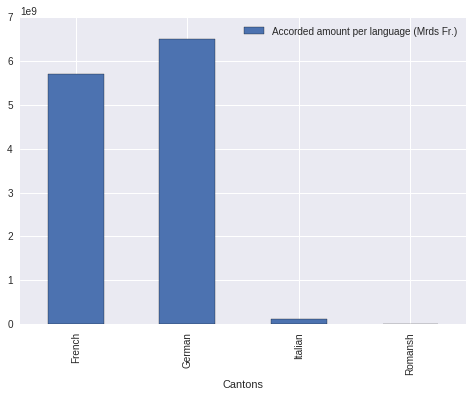

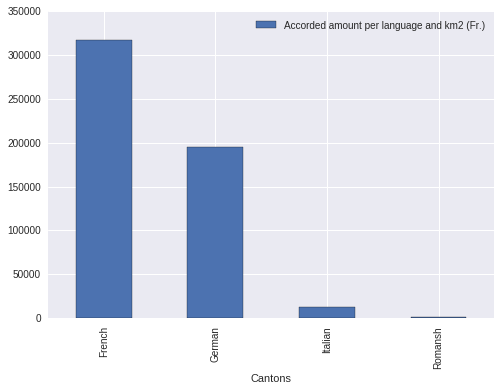

In [47]:
data_graph = pd.DataFrame(data={
                             'Cantons': spoken_languages,
                             'Accorded amount per language (Mrds Fr.)': amount_per_language,
                             'Accorded amount per language and km2 (Fr.)': amount_per_area_and_language
                            })
data_graph.set_index(['Cantons'], inplace=True)
data_graph.plot(kind='bar',y='Accorded amount per language (Mrds Fr.)')
data_graph.plot(kind='bar',y='Accorded amount per language and km2 (Fr.)')

### Analysing data using a map

Let's use Folium, again, to display our results but on a map, this time.

We create one map by language and one map with all languages data:

In [48]:
# We create a set of maps (one map for each language and one global map)
map_lang = {
    'French': folium.Map(location=[46.8, 8.1], zoom_start=8),
    'German': folium.Map(location=[46.8, 8.1], zoom_start=8),
    'Italian': folium.Map(location=[46.8, 8.1], zoom_start=8),
    'Romansh': folium.Map(location=[46.8, 8.1], zoom_start=8),
    'All': folium.Map(location=[46.8, 8.1], zoom_start=8)
}

map_data_lang = cantons_languages_amount.copy()
map_data_lang.reset_index(inplace=True)

# We define colors we will use according to the language
# Available ones are:
# 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu', 'YlGn', 'YlGnBu', 'YlOrBr', and 'YlOrRd'
color = {
    'French': 'BuGn',
    'German': 'BuPu',
    'Italian': 'GnBu',
    'Romansh': 'PuBu'
}

# We set the opacity dynamically because we apply multiple choropleth in the map with all languages
opacity = [0.9,0.6,0.4,0.2]

# For each language
for idx, language in enumerate(spoken_languages):

    # We use, again, the fourth root
    map_data_lang[language] = pow(map_data_lang[language] * map_data_lang['Approved Amount per language'], 1/4)
    
    # We define the scale for each map
    scale = list(
        np.linspace(
            map_data_lang[language].min(),
            map_data_lang[language].max(),
            6
        )
    )

    # We use choropleth for each map, using built dataset and other options
    map_lang[language].choropleth(
        geo_path=topojson_cantons,
        data=map_data_lang,
        columns=['index', language],
        key_on='feature.id',
        fill_color=color[language],
        fill_opacity=0.7,
        line_opacity=0.1,
        threshold_scale=scale,
        legend_name='Grant money by Swiss ' + language + ' universities',
        topojson='objects.cantons'
    )
    
    # We define our global map
    map_lang['All'].choropleth(
        geo_path=topojson_cantons,
        data=map_data_lang,
        columns=['index', language],
        key_on='feature.id',
        fill_color=color[language],
        fill_opacity=opacity[idx],
        line_opacity=0.1,
        threshold_scale=scale,
        legend_name='Grant money by Swiss ' + language + ' universities',
        topojson='objects.cantons'
    )

    
# Finally, we add markers of universities (only in the global map or if the university is in a canton for which considered language is one of the official languages of the aforesaid canton)
universities_locations_canton = match_location_significant.set_index('University').dropna()
for university, row in universities_locations_canton.iterrows():
    for language, map_single in map_lang.items():
        if language == 'All' or cantons_languages_amount.loc[row['Canton']][language] > 0:
            amount = amount_by_university.loc[university]['Approved Amount']
            message = university + ' - ' + row['Canton'] + ' (' + locale.currency( amount, grouping=True ) + ')'
            marker = folium.Marker(row[['Latitude', 'Longitude']], popup=message)
            map_single.add_children(marker)

#### Legend

Again, because of an unknown behavior from Folium (see issue on Slack), we need to define the legend externally. We have, for each map:

- colors (fourth root of approved money by Swiss cantons for a given language) ;
- markers (universities' names and approved money).

#### French-speaking part

In [49]:
map_lang['French'].save('map-approved-amount-french.html')
map_lang['French']

#### German-speaking part

In [50]:
map_lang['German'].save('map-approved-amount-german.html')
map_lang['German']

#### Italian-speaking part

In [51]:
map_lang['Italian'].save('map-approved-amount-italian.html')
map_lang['Italian']

#### Romansh-speaking part

In [52]:
map_lang['Romansh'].save('map-approved-amount-romansh.html')
map_lang['Romansh']

#### Global map

In [53]:
map_lang['All'].save('map-approved-amount-all-languages.html')
map_lang['All']

*Note: There are obvious limitations here, but there are due to Folium. We would get a better visualisation if opacity could have been better managed by default in Folium.*

Using the previous maps, we clearly see, again, that there is a huge gap between the different spoken-language parts of Switzerland. Globally, French-speaking and German-speaking parts are better considered in view of approved amounts and fundraisings (which is quite understandable as 1) territories associated to these parts are larger and as 2) the majority of universities and scientific organisations are located in these parts of Switzerland, because of many reasons of different order).